# CS 234 Project Milestone

Test sandbox for persuasion bandits.

In [1]:
import numpy as np
from math import log

from matplotlib import pyplot as plt

In [46]:
def ucb(q_a, n_a, t):
    """
    Function that chooses an action by upper confidence bound method
    
    INPUT:
        q_a: q function estimates
        n_a: action counts
        t: timestep
        
    OUTPUT:
        ix_0: action on the 0th axis (i.e. p(g | i))
        ix_1: action on the 1st axis (i.e. p(g | g))
    """
    c = 2  # hyperparameter; degree of exploration
    f = q_a + c * np.sqrt(log(t) / (n_a + 1))
    ix_0, ix_1 = np.unravel_index(np.argmax(f), f.shape)  # get max index in the array
    return ix_0, ix_1
    

def persuasion_bandit():
    """
    Function that runs persuasion bandits a la Kamenica 2018

    """
    n_iters = int(2*1e5)
    
    # discrete action space for now. 7 actions
    # to correspond to [GK13] optimum
    n_actions = 8
    
    # set up prior so prior[0] = mu_0(innocent), etc.
    prior = np.array([0.7, 0.3])
    posterior = np.array([0, 0], dtype=float)
    
    # initialize empty q function and action counts. axis 0 denotes choices
    # for p(g | innocent), axis 1 denotes choices for p(g | guilty).
    q_a = np.zeros((n_actions, n_actions))
    n_a = np.zeros((n_actions, n_actions))
    
    # define the reward function; 1 if the judge convicts, 0 otherwise
    r_a = lambda p: 1 if p[1] >= p[0] else 0
    
    # keep track of rewards
    reward_means = []
    batch_rewards = []  # average over 50 samples
    for t in range(1, n_iters):
        if t % 500 == 0:
            reward_means.append(np.mean(batch_rewards))
            batch_rewards = []
        
        # actions: bandit agent chooses p(g | i) and p(g | g)
        # these two probs completely characterize the distribution
        # ix_0: index (= numerator) of p(g | i), (along the 0th axis)
        # ix_1: index (= numerator) of p(g | g), (along the 1st axis)
        ix_0, ix_1 = ucb(q_a, n_a, t)
        
        # get previous estimates for q(a), n(a)
        q_old, n_old = q_a[ix_0, ix_1], n_a[ix_0, ix_1]
        
        # get signal realization probabilities
        p_gi, p_gg = np.divide([ix_0, ix_1], n_actions - 1)
        p_ii, p_ig = 1 - p_gi, 1 - p_gg
        
        # set up matrix so signal[0,0] gets you p(i | innocent), etc.
        pi = np.array([[p_ii, p_ig],[p_gi, p_gg]])
        
        # sample state of the world; 1 = guilty, 0 = innocent
        state = np.random.choice([0, 1], p=prior)
        
        # signal realization
        if state == 1:
            signal = np.random.choice([0, 1], p=[p_ig, p_gg])
        elif state == 0:
            signal = np.random.choice([0, 1], p=[p_ii, p_gi])
        
        # form posterior for each state
        denom = (pi[signal, :] @ prior)
        posterior[0] = (pi[signal, 0] * prior[0]) / denom
        posterior[1] = (pi[signal, 1] * prior[1]) / denom
        
        # get the reward
        batch_rewards.append(r_a(posterior))
        n_a[ix_0, ix_1] += 1
        q_a[ix_0, ix_1] += (r_a(posterior) - q_old) / n_a[ix_0, ix_1]
        
    return q_a, n_a, ucb(q_a, n_a, n_iters), reward_means
    
    

In [47]:
q_a, n_a, ucb, rs = persuasion_bandit()

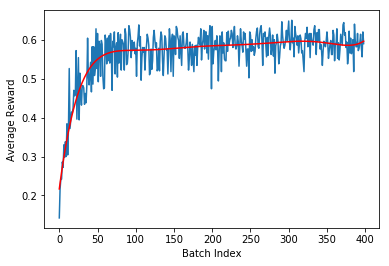

In [48]:
line = np.poly1d(np.polyfit(x=range(len(rs)), y=np.array(rs), deg=7))
plt.plot(rs)
plt.plot(line(range(len(rs))), 'r-')
plt.xlabel('Batch Index')
plt.ylabel('Average Reward')
plt.show()

In [36]:
np.unravel_index(np.argmax(q_a), q_a.shape)

(3, 7)